In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display
from PIL import Image
import pickle
import os
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
display(device)
print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"Memory Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

def show_tensor(tensor): 
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

def show_bound_boxes(image, boxes, labels, tensor=False):
    _, ax = plt.subplots()
    if tensor: 
        image = image.numpy().transpose(1, 2, 0)
    ax.imshow(image)
    plt.title("Bounding Boxes")
    for box, label in zip(boxes, labels):
        color = "red" if label == 0 else "green"
        width, height = box[2] - box[0], box[3] - box[1]
        bounding_box = patches.Rectangle((box[0], box[1]), width, height ,edgecolor=color, facecolor='none')
        ax.add_patch(bounding_box)

def show_sample(sample, tensor=False, numpy=False):
    if numpy: image, targets = sample
    else: image, targets = sample.values
    boxes = targets["boxes"]
    labels = targets["labels"]
    _, ax = plt.subplots()
    if tensor: 
        image = image.numpy().transpose(1, 2, 0)
    ax.imshow(image)
    plt.title("Bounding Boxes")
    for box, label in zip(boxes, labels):
        color = "red" if label == 0 else "green"
        width, height = box[2] - box[0], box[3] - box[1]
        bounding_box = patches.Rectangle((box[0], box[1]), width, height ,edgecolor=color, facecolor='none')
        ax.add_patch(bounding_box)

c:\Users\Yug\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

Total Memory: 6.44 GB
Memory Reserved: 0.00 GB
Memory Allocated: 0.00 GB


# Loading Data

In [2]:
df = pd.read_pickle("../data/formatted_800x600.pickle")

In [38]:
with open("../data/formatted_800x600.pickle", "wb") as f: 
    pickle.dump(df, f)

In [3]:
class MalariaDataset(Dataset): 
    def __init__(self, df, transform=None): 
        self.df = df
        self.transform = transform

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, index): 
        image, targets = self.df[index]
        if self.transform: 
            image = self.transform(image)
        return image, targets
        
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(list(images))
    return images, targets

def get_loader(df, batch_size=32, transform=None): 
    dataset = MalariaDataset(df, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [4]:
np_df = df.to_numpy()
np.random.seed(1000)
np.random.shuffle(np_df)
n = len(np_df)
n_trn = int(n*0.8)
n_val = int(n*0.9)

df_trn = np_df[:n_trn]
df_val = np_df[n_trn:n_val]
df_tst = np_df[n_val:]

In [5]:
batch_size = 2

trn_loader = get_loader(df_trn, batch_size, transforms.ToTensor())
val_loader = get_loader(df_val, batch_size, transforms.ToTensor())
tst_loader = get_loader(df_tst, batch_size, transforms.ToTensor())

# Fast R-CNN


In [8]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(features, 2)
model.roi_heads.to(device)

model_path = f"./faster_rcnn/detection/"

In [9]:
def uni_label(targets):
    for i in range(len(targets)): 
        targets[i]["labels"] = torch.ones(len(targets[i]["labels"]), dtype=torch.int64)
    return targets

## Training Detection

In [10]:
def train(model, loader, model_path, learning_rate=0.001, epoches=50):
    model.train()
    torch.manual_seed(1000)

    try: os.mkdir(model_path)
    except: assert os.path.isdir(model_path)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    n = len(loader)

    for epoch in range(epoches):
        epoch_loss = 0
        for i, (images, targets) in enumerate(loader):
            images = images.to(device)
            model_targets = uni_label(copy.deepcopy(targets))
            model_targets = [{k: v.to(device) for k, v in t.items()} for t in model_targets]
            loss_dict = model(images, model_targets)
            loss = sum(l for l in loss_dict.values())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            # if i % 50 == 0:
            #     print(f" Step {'%.3d' % i}/{n} Loss {loss.item():.6f}")

        scheduler.step()
        print(f"Epoch {'%.2d' % (epoch + 1)}/{epoches} Loss: {loss.item():.6f}")

        torch.save(model.state_dict(), model_path + f"epoch_{epoch + 1}.pt")

In [11]:
train(model, trn_loader, model_path)

Epoch 01/50 Loss: 0.395425
Epoch 02/50 Loss: 0.297886
Epoch 03/50 Loss: 0.258166
Epoch 04/50 Loss: 0.233014
Epoch 05/50 Loss: 0.207590
Epoch 06/50 Loss: 0.200515
Epoch 07/50 Loss: 0.247512
Epoch 08/50 Loss: 0.191645
Epoch 09/50 Loss: 0.215967
Epoch 10/50 Loss: 0.188353
Epoch 11/50 Loss: 0.185676
Epoch 12/50 Loss: 0.172213
Epoch 13/50 Loss: 0.177514
Epoch 14/50 Loss: 0.145645
Epoch 15/50 Loss: 0.165326
Epoch 16/50 Loss: 0.181409
Epoch 17/50 Loss: 0.180653
Epoch 18/50 Loss: 0.144314
Epoch 19/50 Loss: 0.149516
Epoch 20/50 Loss: 0.152107
Epoch 21/50 Loss: 0.155119
Epoch 22/50 Loss: 0.145321
Epoch 23/50 Loss: 0.134626
Epoch 24/50 Loss: 0.143438
Epoch 25/50 Loss: 0.147883
Epoch 26/50 Loss: 0.139787
Epoch 27/50 Loss: 0.157112
Epoch 28/50 Loss: 0.124829
Epoch 29/50 Loss: 0.136593
Epoch 30/50 Loss: 0.106112
Epoch 31/50 Loss: 0.129566
Epoch 32/50 Loss: 0.124885
Epoch 33/50 Loss: 0.126286
Epoch 34/50 Loss: 0.131636
Epoch 35/50 Loss: 0.109873
Epoch 36/50 Loss: 0.102200
Epoch 37/50 Loss: 0.107354
E

## Model Performance

### Loading the Model

In [10]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(features, 2)
model.to(device)
model.roi_heads.to(device)
model_path = f"./faster_rcnn/detection/"
model.load_state_dict(torch.load(model_path + "epoch_50.pt"))
print("Model Loaded")

Model Loaded


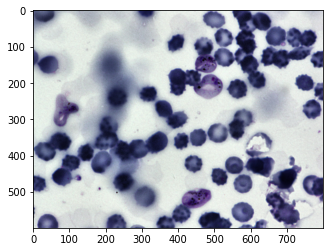

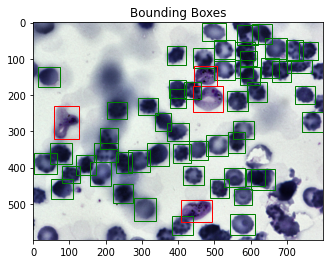

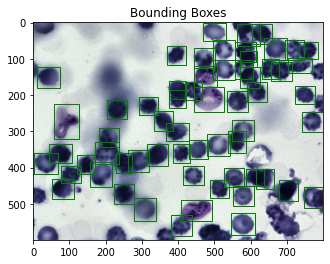

In [28]:
for images, targets in val_loader: 
    images = images.to(device)
    outputs = model(images)
    for i, (image, output, target) in enumerate(zip(images, outputs, targets)): 
        if i == 0: continue
        boxes = output["boxes"].cpu().detach()
        labels = output["labels"].cpu().detach()
        show_tensor(image.cpu())
        show_bound_boxes(image.cpu().detach(), target["boxes"], target["labels"], tensor=True)
        show_bound_boxes(image.cpu().detach(), boxes, labels, tensor=True)
    break